In [16]:
import pandas as pd
import time
import flickrapi
import json
import datetime
import csv
import numpy as np

import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

import matplotlib.pyplot as plt
from pylab import savefig
import matplotlib.ticker as mtick


api_key = 
api_secret = 
flickr = flickrapi.FlickrAPI(api_key, api_secret)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))


<B>Retrieving Flickr data </B>

In [ ]:
with open('./output/sample_flickr.csv', 'w') as csvFile:
    fieldnames = ['photo_id','photo_title','username','date_posted','date_taken','user_location','lat','lon']
    writer = csv.DictWriter(csvFile, fieldnames=fieldnames,lineterminator = '\n')
    writer.writeheader()
    
    for photo in flickr.walk(per_page=500,tag_mode='any',tags='amsterdam',extras="geo",
                             bbox="4.702148,52.282442,5.059891,52.459775"):
        try:
            photo_title = photo.attrib['title']
            photo_id = photo.attrib['id']
            lat = photo.attrib['latitude']
            lon =  photo.attrib['longitude']
            
            bulk_info_byte = flickr.photos.getInfo(photo_id=photo_id,format='json')
            json = bulk_info_byte.decode('utf8')
            username = (json[json.find('"username":"')+len('"username":"'):json.rfind('","realname"')])
            date_posted = json[json.find('"dates":{"posted":"')+len('"dates":{"posted":"'):json.rfind('","taken"')]
            date_posted = datetime.datetime.fromtimestamp(int(date_posted))
            date_taken = json[json.find('"taken":"')+len('"taken":"'):json.rfind('","takengranularity"')]
            date_taken = datetime.datetime.strptime(date_taken, '%Y-%m-%d %H:%M:%S')
            user_location = json[json.find('"location":"')+len('"location":"'):json.rfind('","iconserver"')]
            
            writer.writerow({'photo_id': photo_id,'photo_title': photo_title,'username':username,'date_posted':date_posted,
                             'date_taken':date_taken,'user_location':user_location,'lat': lat,'lon':lon})
            time.sleep(1)
            print(username)
        except (FlickrError,NameError,UnicodeEncodeError) as e:
            time.sleep(30)

In [ ]:
#example to get all photos uploaded from a single user
user_id = '88550037@N08'
#get information about user's album
#flickr.photosets_getList(user_id=user_id,format='json')
#get all photos
flickr.people.getPhotos(per_page=500,user_id=user_id,format='json')

<B>Cleaning data </B>

In [4]:
df = pd.read_csv('./output/sample_flickr_24june2019.csv',encoding = "ISO-8859-1")
df['date_taken'] = pd.to_datetime(df['date_taken'])
df['date_posted'] = pd.to_datetime(df['date_posted'])
df['country'] = df["user_location"]
df['country'] = df["user_location"].str.split(",", n = 1, expand = True)[[1]]
df['country'] = df['country'].str.strip()
df.fillna(value='-',inplace=True)
df["traveler_type"] = ""
df['country']= np.where(df['country']=='-', df['user_location'], df['country'])

In [5]:
#label based on country
nl = ['Nederland','Netherlands','The Netherlands','Holland','NL','the Netherlands','nederland']
df.loc[df['country'].isin(nl),'traveler_type'] = 'domestic'
df.loc[df['user_location'].str.contains('Amsterdam'),'traveler_type'] = 'local'
df.loc[df['user_location'].str.contains('Utrecht'),'traveler_type'] = 'domestic'

df.loc[df['user_location'].str.contains('Amsterdam'),'traveler_type'] = 'local'

In [6]:
subset = df.loc[df['user_location']=='-'].groupby(['username','date_taken']).size().reset_index()
subset['month_nr'] = subset['date_taken'].apply(lambda x: "%d" % (x.month))
subset = subset.groupby(['username', 'month_nr']).size().reset_index(name='photo_frequency')

# label based on amount of photos per month
# international more than 100 photos, domestic between 10-100, local less than 10
subset.loc[subset['photo_frequency']>100,'traveler_type'] = 'international'
subset.loc[(subset['photo_frequency']>=10) & (subset['photo_frequency']<=100),'traveler_type']= 'domestic'
subset.loc[subset['photo_frequency']<10,'traveler_type'] = 'local'
subset = subset.groupby(['username','traveler_type']).size().reset_index(name='count')
subset.drop(columns='count',inplace=True)
df = df.merge(subset,on='username',how = 'outer')
df['traveler_type_x']= np.where(df['traveler_type_x']=='', df['traveler_type_y'], df['traveler_type_x'])
df.drop(columns='traveler_type_y',inplace=True)
df.rename(columns={'traveler_type_x': 'traveler_type'}, inplace=True)

df.loc[df['traveler_type'].isnull(),'traveler_type']='international'

df = df.drop_duplicates(subset='photo_id', keep='first')

In [7]:
df

,photo_id,photo_title,username,date_posted,date_taken,user_location,lat,lon,country,traveler_type
0,48121305478,Korean B777,Ramon Kok,2019-06-24 18:54:11,2019-06-16 21:28:46,"De Kwakel, The Netherlands",52.320958,4.768694,The Netherlands,domestic
1,48121304683,Korean B777,Ramon Kok,2019-06-24 18:54:11,2019-06-16 21:28:55,"De Kwakel, The Netherlands",52.320958,4.768694,The Netherlands,domestic
2,48121269261,Korean B777,Ramon Kok,2019-06-24 18:54:11,2019-06-16 21:29:15,"De Kwakel, The Netherlands",52.321366,4.768175,The Netherlands,domestic
3,48116063661,Etihad B777,Ramon Kok,2019-06-23 22:26:35,2019-06-16 21:43:56,"De Kwakel, The Netherlands",52.321127,4.768141,The Netherlands,domestic
4,48116062926,Etihad B777,Ramon Kok,2019-06-23 22:26:35,2019-06-16 21:44:14,"De Kwakel, The Netherlands",52.321211,4.768397,The Netherlands,domestic
5,48116062406,Etihad B777,Ramon Kok,2019-06-23 22:26:35,2019-06-16 21:44:51,"De Kwakel, The Netherlands",52.321211,4.768397,The Netherlands,domestic
6,48113779987,Qatar B777,Ramon Kok,2019-06-23 15:20:21,2019-06-02 17:04:21,"De Kwakel, The Netherlands",52.321197,4.771900,The Netherlands,domestic
7,48113779472,Lufthansa A320,Ramon Kok,2019-06-23 15:20:17,2019-06-02 18:40:50,"De Kwakel, The Netherlands",52.321369,4.771072,The Netherlands,domestic
8,48113778837,Avantair F100,Ramon Kok,2019-06-23 15:20:21,2019-06-02 17:10:41,"De Kwakel, The Netherlands",52.321844,4.770552,The Netherlands,domestic
9,48113679231,Norwegian B737,Ramon Kok,2019-06-23 15:20:17,2019-06-02 18:47:50,"De Kwakel, The Netherlands",52.321369,4.771072,The Netherlands,domestic


<b>Plot</b>

In [13]:
poly = gpd.read_file('./data/amsterdam_neighbourhoods.geojson', driver='GeoJSON')

In [10]:
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
df = df.drop(['lat', 'lon'], axis=1)
flickr_gdf = GeoDataFrame(df, crs={'init': 'epsg:4326'}, geometry=geometry)


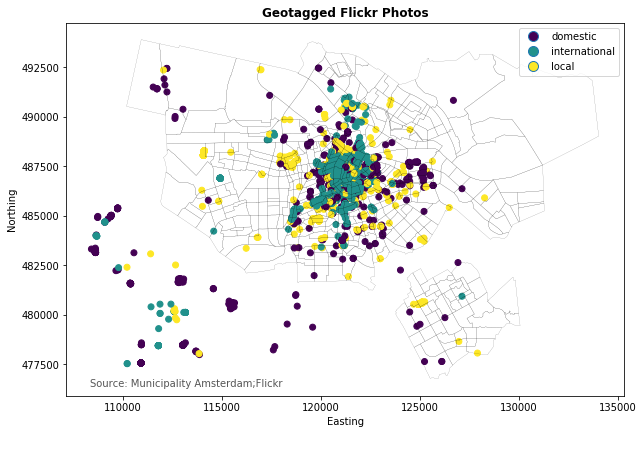

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
rdnew_crs = {'init' :'epsg:28992'}
ax.set_title("Geotagged Flickr Photos", fontsize=12,fontweight='bold')
flickr_gdf.to_crs(rdnew_crs).plot(column='traveler_type', ax=ax,cmap='viridis',legend=True)
poly.to_crs(rdnew_crs).geometry.boundary.plot(color=None,edgecolor='black',linewidth=0.1,ax=ax)
ax.set(xlabel="Easting", ylabel="Northing")
ax.annotate("Source: Municipality Amsterdam;Flickr",xy=(0.14, .16), xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=10, color='#555555')
plt.savefig("./images/FlickrGeotagged.png",bbox_inches = "tight",dpi=300)